# Exploratory Data Analysis (EDA)

The goal of this notebook is to understand the structure and quality of the collected audio dataset. The analysis includes:
1. **Metadata Verification:** Checking class balance and speaker distribution.
2. **Audio Signal Analysis:** Extracting features such as duration, RMS energy (loudness), and spectrogram statistics.
3. **Data Visualization:** Using histograms, box plots, and parallel coordinates to find patterns.
4. **Anomaly Detection:** Identifying files that are too quiet or too short, which may need to be removed.

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pandas.plotting import parallel_coordinates
import os

RECORDING_DIR = '../data_recordings'
PLOT_DPI = 200

# Set a consistent style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

# 1. Configuration and Data Verification
First, we ensure that the manifest file and the recordings directory are accessible.

In [2]:
MANIFEST_PATH = os.path.join(RECORDING_DIR, 'manifest.csv')

print(f"Checking configuration...")
if not os.path.exists(RECORDING_DIR):
    raise FileNotFoundError(
        f"\n[ERROR] The directory '{RECORDING_DIR}' was not found.\n"
        f"Please ensure you have created the folder and extracted your data there.\n"
        f"Run python script: run_pipeline_to_get_data.py"
    )

if not os.path.exists(MANIFEST_PATH):
        raise FileNotFoundError(
            f"\n[ERROR] 'manifest.csv' was not found in '{RECORDING_DIR}'.\n"
            f"Please ensure you have created manifest file into '{RECORDING_DIR}' or update the path.\n"
            f"Run python script: run_pipeline_to_get_data.py"
        )

print(f"[OK] Directory and file exists.")

Checking configuration...
[OK] Directory and file exists.


In [3]:
df = pd.read_csv(MANIFEST_PATH)
df.path = RECORDING_DIR + '/' + df.path

# 2. Files analysis 

## Data Structure Overview
A quick look at the first few rows to ensure file paths and speaker IDs are correct.

In [4]:
print("Manifest Info:")
df.info()

print("\nHead of the DataFrame:")
display(df.head())

Manifest Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11225 entries, 0 to 11224
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   speaker_id  11225 non-null  object
 1   path        11225 non-null  object
 2   label       11225 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 263.2+ KB

Head of the DataFrame:


,speaker_id,path,label
0,p226,../data_recordings/rejected/p226/p226_001_000.wav,0
1,p226,../data_recordings/rejected/p226/p226_002_000.wav,0
2,p226,../data_recordings/rejected/p226/p226_002_001.wav,0
3,p226,../data_recordings/rejected/p226/p226_002_002.wav,0
4,p226,../data_recordings/rejected/p226/p226_003_000.wav,0


## Class Balance Analysis
We check if the dataset is balanced. The ideal situation is to have a similar number of samples for class `0` (rejected) and `1` (accepted).

In [5]:
print(f"Total files: {len(df)}")

# Analyze Class Balance
print("\nClass Distribution:")
class_counts = df['label'].value_counts()
print(class_counts)

Total files: 11225

Class Distribution:
label
0    6005
1    5220
Name: count, dtype: int64


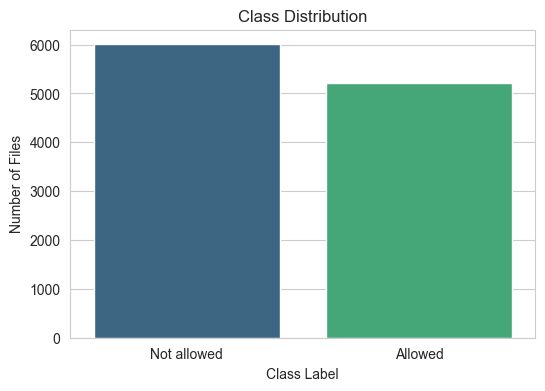

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis', hue='label', legend=False)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Files')
plt.xticks([0, 1], ['Not allowed', 'Allowed'])
plt.savefig('plots/file_distr_by_class', dpi=PLOT_DPI)
plt.show()

## Speaker Analysis
It is crucial that **the same speaker does not appear in both classes**. If the model learns "who is speaking" instead of "what/how they are speaking", and the same speaker is in both the training and test sets in different classes, the results may be skewed (data leakage).

The chart below also shows if some speakers dominate the dataset (which could bias the model towards their specific voice timbre).

Total number of unique speakers: 26


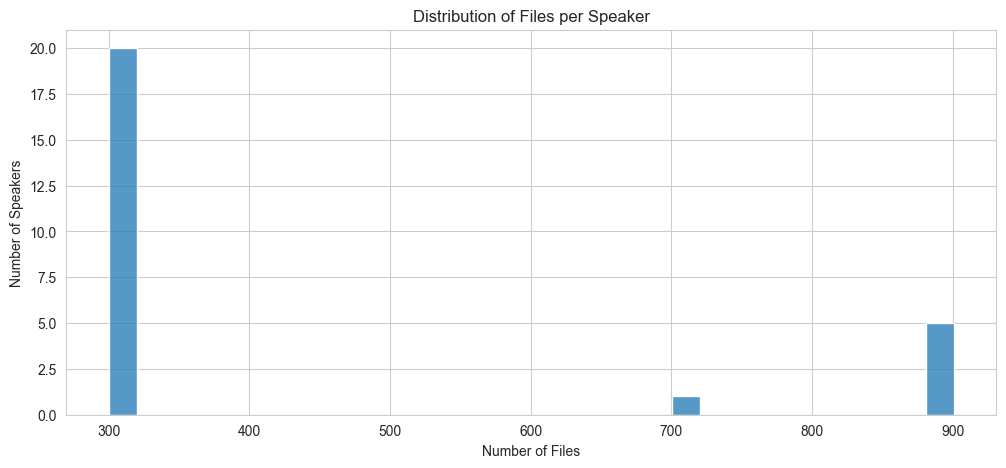


Speakers appearing in only one class: 26
Speakers appearing in both classes: 0


In [7]:
# 1. Count Speakers
num_speakers = df['speaker_id'].nunique()
print(f"Total number of unique speakers: {num_speakers}")

# 2. Files per Speaker
speaker_file_counts = df['speaker_id'].value_counts()
# print("\nFiles per speaker (Top 5):")
# print(speaker_file_counts.head())
# print("\nFiles per speaker (Bottom 5):")
# print(speaker_file_counts.tail())

plt.figure(figsize=(12, 5))
sns.histplot(speaker_file_counts, bins=30)
plt.title('Distribution of Files per Speaker')
plt.xlabel('Number of Files')
plt.ylabel('Number of Speakers')
plt.savefig('plots/file_distr_by_speaker', dpi=PLOT_DPI)
plt.show()

# 3. Speaker-Class Overlap
speaker_labels = df.groupby('speaker_id')['label'].nunique()
print(f"\nSpeakers appearing in only one class: {(speaker_labels == 1).sum()}")
print(f"Speakers appearing in both classes: {(speaker_labels > 1).sum()}")

# 3. Audio analysis
Now we analyze the `.wav` files themselves. We extract key metrics:
* **Duration:** Files that are too short (<1s) may not contain useful information.
* **RMS Energy (Loudness):** Root mean square amplitude. Allows detecting empty recordings (silence).
* **Sampling Rate:** We ensure all files have a consistent sampling rate (e.g., 22050 Hz).
* **Spectrogram Stats:** Mean and standard deviation from the mel-spectrogram will give us an overall picture of the "brightness" and contrast of the images that will go into the CNN.

In [8]:
# Create lists to store extracted features
durations = []
sampling_rates = []
channels = []
rms_energies = []
spec_means = [] # Mean pixel intensity of spectrogram
spec_stds = []  # Contrast of spectrogram

print("Extracting features...")
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        y, sr = librosa.load(row['file_path'])
        
        durations.append(librosa.get_duration(y=y, sr=sr))
        sampling_rates.append(sr)
        channels.append(y.shape[0] if y.ndim > 1 else 1)
        rms_energies.append(np.mean(librosa.feature.rms(y=y)))
        
        # 3. Spectrogram Stats
        hop_length = 512
        n_mels = 128
        mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
        mels_log = np.log(mels + 1e-9)
        
        spec_means.append(np.mean(mels_log))
        spec_stds.append(np.std(mels_log))
        
    except Exception as e:
        print(f"Error with {row['file_path']}: {e}")
        durations.append(None)
        rms_energies.append(None)
        spec_means.append(None)
        spec_stds.append(None)

# Assign back to dataframe
df['duration'] = durations
df['sampling_rate'] = sampling_rates
df['channels'] = channels
df['rms_energy'] = rms_energies
df['spec_mean'] = spec_means
df['spec_std'] = spec_stds

# Drop any failed loads
df.dropna(inplace=True)

Extracting features...


  0%|                                                                                        | 0/11225 [00:01<?, ?it/s]


KeyError: 'file_path'

## Recording Duration Distribution
The histogram below shows how long the recordings are in each class.

In [ ]:
print("\nAudio Properties Analyzed:")
display(df.head())

# Analyze Properties
print("\nUnique Sampling Rates:")
print(df['sampling_rate'].value_counts())

print("\nUnique Channel Counts:")
print(df['channels'].value_counts())

# Plot duration
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='duration', hue='label', bins=40, multiple="stack")
plt.title(f'Distribution of Audio Durations by Class')
plt.xlabel('Duration (seconds)')
plt.savefig('plots/duration_hist', dpi=PLOT_DPI)
plt.show()

## Total Recording Time
The sum of recording durations in each class. Even if the number of files is equal, one class can have significantly shorter recordings, meaning the model "sees" less data of that class during training.

In [ ]:
duration_sum = df.groupby('label')['duration'].sum().reset_index()

# (Optional) Convert to minutes for better readability if you have a lot of data
duration_sum['duration_min'] = duration_sum['duration'] / 60

# 2. Plot
plt.figure(figsize=(6, 5))
ax = sns.barplot(x='label', y='duration_min', data=duration_sum, hue='label', palette='viridis', legend=False)
plt.title('Total Audio Duration per Class')
plt.xlabel('Class')
plt.ylabel('Total Duration (minutes)')
plt.xticks([0, 1], ['Not allowed', 'Allowed'])
plt.savefig('plots/duration_by_class', dpi=PLOT_DPI)
plt.show()

## Elementary Statistics and Box Plots
Box plots are great for showing data distribution and outliers.
* **Duration:** Everything looks fine.
* **RMS Energy:** Dots at the very bottom are almost silent recordings (silence/background noise) that can confuse the model.

In [ ]:
# Box Plots for Duration and Energy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Duration Box Plot
sns.boxplot(x='label', y='duration', data=df, ax=axes[0], palette='coolwarm', hue='label', legend=False)
axes[0].set_title('Audio Duration Distribution')

# Energy Box Plot
sns.boxplot(x='label', y='rms_energy', data=df, ax=axes[1], palette='coolwarm', hue='label', legend=False)
axes[1].set_title('RMS Energy (Loudness) Distribution')

plt.tight_layout()
plt.savefig('plots/stats_by_class', dpi=PLOT_DPI)
plt.show()

## Multidimensional Analysis (Parallel Coordinates)
A parallel coordinates plot allows checking if a combination of features (Duration, Energy, Spectrogram Brightness) easily separates class `0` from `1`. Lines for both classes are completely mixed, it means simple statistics are not enough and we need a deep neural network (CNN) to find patterns.

In [ ]:
plot_df = df[['duration', 'rms_energy', 'spec_mean', 'spec_std', 'label']].copy()

# Min-Max normalization
for col in ['duration', 'rms_energy', 'spec_mean', 'spec_std']:
    max_min_diff = plot_df[col].max() - plot_df[col].min()
    if max_min_diff == 0:
        plot_df[col] = 1
    else:
        plot_df[col] = (plot_df[col] - plot_df[col].min()) / max_min_diff

plt.figure(figsize=(12, 6))
parallel_coordinates(plot_df, 'label', color=('#FF6347', '#4682B4'), alpha=0.3)
plt.title('Parallel Coordinates Plot: Feature Separation')
plt.xlabel('Features')
plt.ylabel('Normalized Value')
plt.savefig('plots/multidimensional', dpi=PLOT_DPI)
plt.show()

## Anomaly Detection (Percentiles and Gaussian)
We look for files that fall in the bottom 5% in terms of energy. These are candidates for removal from the training set as "silence" or "background noise". The density plot (KDE) shows if the energy distribution resembles a normal (Gaussian) distribution.

In [ ]:
# Percentile-based analysis
lower_bound = np.percentile(df['rms_energy'], 5)
upper_bound = np.percentile(df['rms_energy'], 95)

print(f"Energy 5th percentile: {lower_bound:.4f}")
print(f"Energy 95th percentile: {upper_bound:.4f}")

# Identify potential "Silent" outliers 
outliers = df[df['rms_energy'] < lower_bound]
print(f"Found {len(outliers)} potential silent files (Outliers).")
display(outliers.head())

# 2. Gaussian Distribution Visualization
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='rms_energy', hue='label', fill=True)
plt.title('Density Plot')
plt.xlabel('RMS Energy')
plt.savefig('plots/energy_density', dpi=PLOT_DPI)
plt.show()

## Visual Inspection of Spectrograms
Finally, we generate sample Mel-spectrograms for both classes. This allows for a visual assessment of data quality – whether clear harmonic structures (human voice) are visible or just blurry noise.

In [ ]:
def custom_spec_plot(y, sr, ax, title):
    """Adapted from your spectrogram_data.py for subplotting"""
    hop_length = 512
    n_fft = 2048
    mel_signal = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    
    img = librosa.display.specshow(power_to_db, sr=sr, x_axis="time", y_axis="mel", 
                                   cmap="magma", hop_length=hop_length, ax=ax)
    ax.set_title(title)
    return img

# Pick 3 random Accepted and 3 random Rejected
accepted_samples = df[df['label'] == 1].sample(3)
rejected_samples = df[df['label'] == 0].sample(3)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Visual Comparison: Rejected (Top) vs Accepted (Bottom)")

# Plot Rejected
for i, (_, row) in enumerate(rejected_samples.iterrows()):
    y, sr = librosa.load(row['file_path'], sr=22050)
    custom_spec_plot(y, sr, axes[0, i], f"Rejected: {row['speaker_id']}")

# Plot Accepted
for i, (_, row) in enumerate(accepted_samples.iterrows()):
    y, sr = librosa.load(row['file_path'], sr=22050)
    custom_spec_plot(y, sr, axes[1, i], f"Accepted: {row['speaker_id']}")

plt.tight_layout()
plt.savefig('plots/sample_spectograms', dpi=PLOT_DPI)
plt.show()